In [ ]:
%pip install prophet


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [33]:
# Read the Excel file
df = pd.read_excel('data/retail_sales.xlsx')

print(df.head().to_markdown())


|    |   Transaction ID | Date                | Customer ID   | Gender   |   Age | Product Category   |   Quantity |   Price per Unit |   Total Amount |
|---:|-----------------:|:--------------------|:--------------|:---------|------:|:-------------------|-----------:|-----------------:|---------------:|
|  0 |                1 | 2023-11-24 00:00:00 | CUST001       | Male     |    34 | Beauty             |          3 |               50 |            150 |
|  1 |                2 | 2023-02-27 00:00:00 | CUST002       | Female   |    26 | Clothing           |          2 |              500 |           1000 |
|  2 |                3 | 2023-01-13 00:00:00 | CUST003       | Male     |    50 | Electronics        |          1 |               30 |             30 |
|  3 |                4 | 2023-05-21 00:00:00 | CUST004       | Male     |    37 | Clothing           |          1 |              500 |            500 |
|  4 |                5 | 2023-05-06 00:00:00 | CUST005       | Male     |    30 |

In [34]:

# print the column names
print(df.columns)


Index(['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'Price per Unit', 'Total Amount'],
      dtype='object')


In [35]:
# change column names to be snake case
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    1000 non-null   int64         
 1   date              1000 non-null   datetime64[ns]
 2   customer_id       1000 non-null   object        
 3   gender            1000 non-null   object        
 4   age               1000 non-null   int64         
 5   product_category  1000 non-null   object        
 6   quantity          1000 non-null   int64         
 7   price_per_unit    1000 non-null   int64         
 8   total_amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [37]:
df.describe()

,transaction_id,date,age,quantity,price_per_unit,total_amount
count,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,2023-07-03 00:25:55.200000256,41.39200,2.514000,179.890000,456.000000
min,1.000000,2023-01-01 00:00:00,18.00000,1.000000,25.000000,25.000000
25%,250.750000,2023-04-08 00:00:00,29.00000,1.000000,30.000000,60.000000
50%,500.500000,2023-06-29 12:00:00,42.00000,3.000000,50.000000,135.000000
75%,750.250000,2023-10-04 00:00:00,53.00000,4.000000,300.000000,900.000000
max,1000.000000,2024-01-01 00:00:00,64.00000,4.000000,500.000000,2000.000000
std,288.819436,NaN,13.68143,1.132734,189.681356,559.997632


In [38]:
# Convert timestamp to date fields
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayOfWeek'] = df['date'].dt.dayofweek

# Clear out Datetime field
df = df.drop(columns=['date'])

In [39]:
print(df.head().to_markdown())

|    |   transaction_id | customer_id   | gender   |   age | product_category   |   quantity |   price_per_unit |   total_amount |   year |   month |   day |   dayOfWeek |
|---:|-----------------:|:--------------|:---------|------:|:-------------------|-----------:|-----------------:|---------------:|-------:|--------:|------:|------------:|
|  0 |                1 | CUST001       | Male     |    34 | Beauty             |          3 |               50 |            150 |   2023 |      11 |    24 |           4 |
|  1 |                2 | CUST002       | Female   |    26 | Clothing           |          2 |              500 |           1000 |   2023 |       2 |    27 |           0 |
|  2 |                3 | CUST003       | Male     |    50 | Electronics        |          1 |               30 |             30 |   2023 |       1 |    13 |           4 |
|  3 |                4 | CUST004       | Male     |    37 | Clothing           |          1 |              500 |            500 |   2023 | 

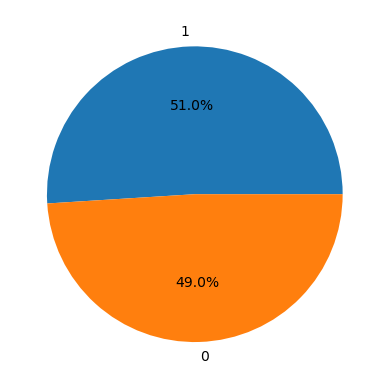

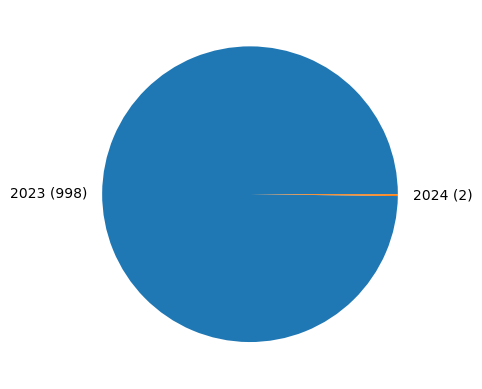

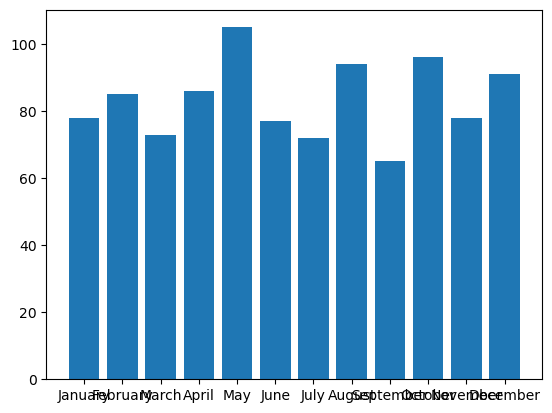

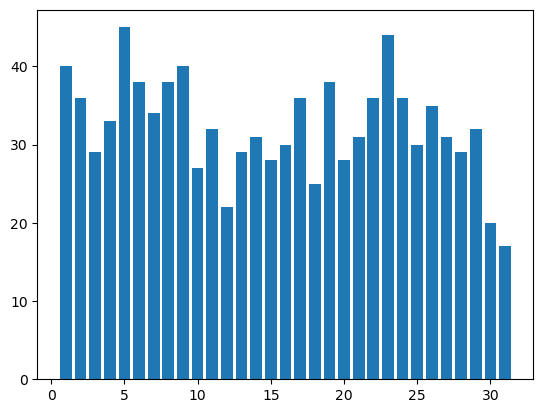

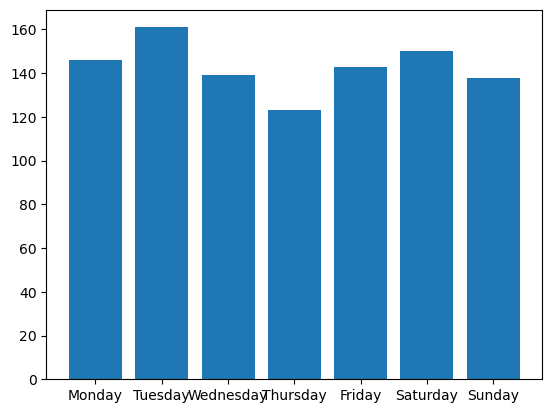

In [66]:
# Single Variate Analysis

## Population by gender
gender_counts = df['gender'].value_counts()
plt.pie(gender_counts, labels=df['gender'].unique(), autopct='%1.1f%%')
plt.show()

## Transactions by Day/Moth/Year
year_counts = df['year'].value_counts()
labels = [f"{lab} ({cnt})" for lab, cnt in zip(year_counts.index, year_counts)]
plt.pie(year_counts, labels=labels)
plt.show()

month_counts = df['month'].value_counts().sort_index()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.bar(x=months, height=month_counts.to_list())
plt.show()

day_counts = df['day'].value_counts().sort_index()
plt.bar(x=range(1,32), height=day_counts.to_list())
plt.show()

dayOfWeek_counts = df['dayOfWeek'].value_counts().sort_index()
plt.bar(x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], height=dayOfWeek_counts.to_list())
plt.show()

In [41]:
# Convert 'Customer ID' and 'Gender' to categorical codes

# print(df.head().to_markdown())
df['customer_id'] = df['customer_id'].astype('category').cat.codes
df['gender'] = df['gender'].astype('category').cat.codes
df['product_category'] = df['product_category'].astype('category').cat.codes




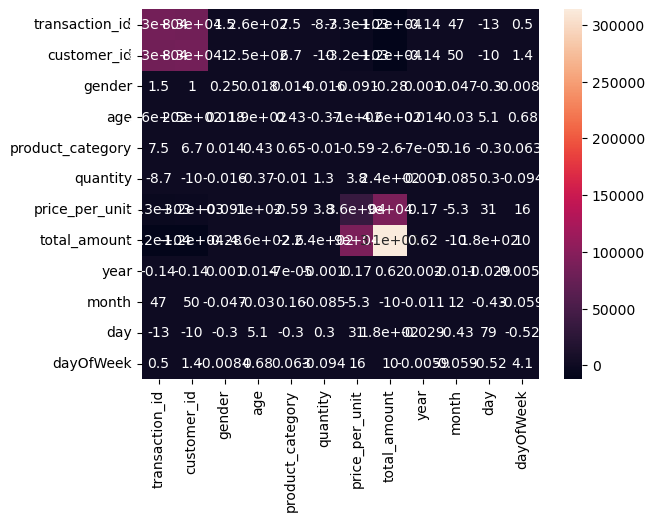

In [42]:
# Covariate Analysis
covariance_matrix = df.cov()
sns.heatmap(covariance_matrix, annot=True)
plt.show()


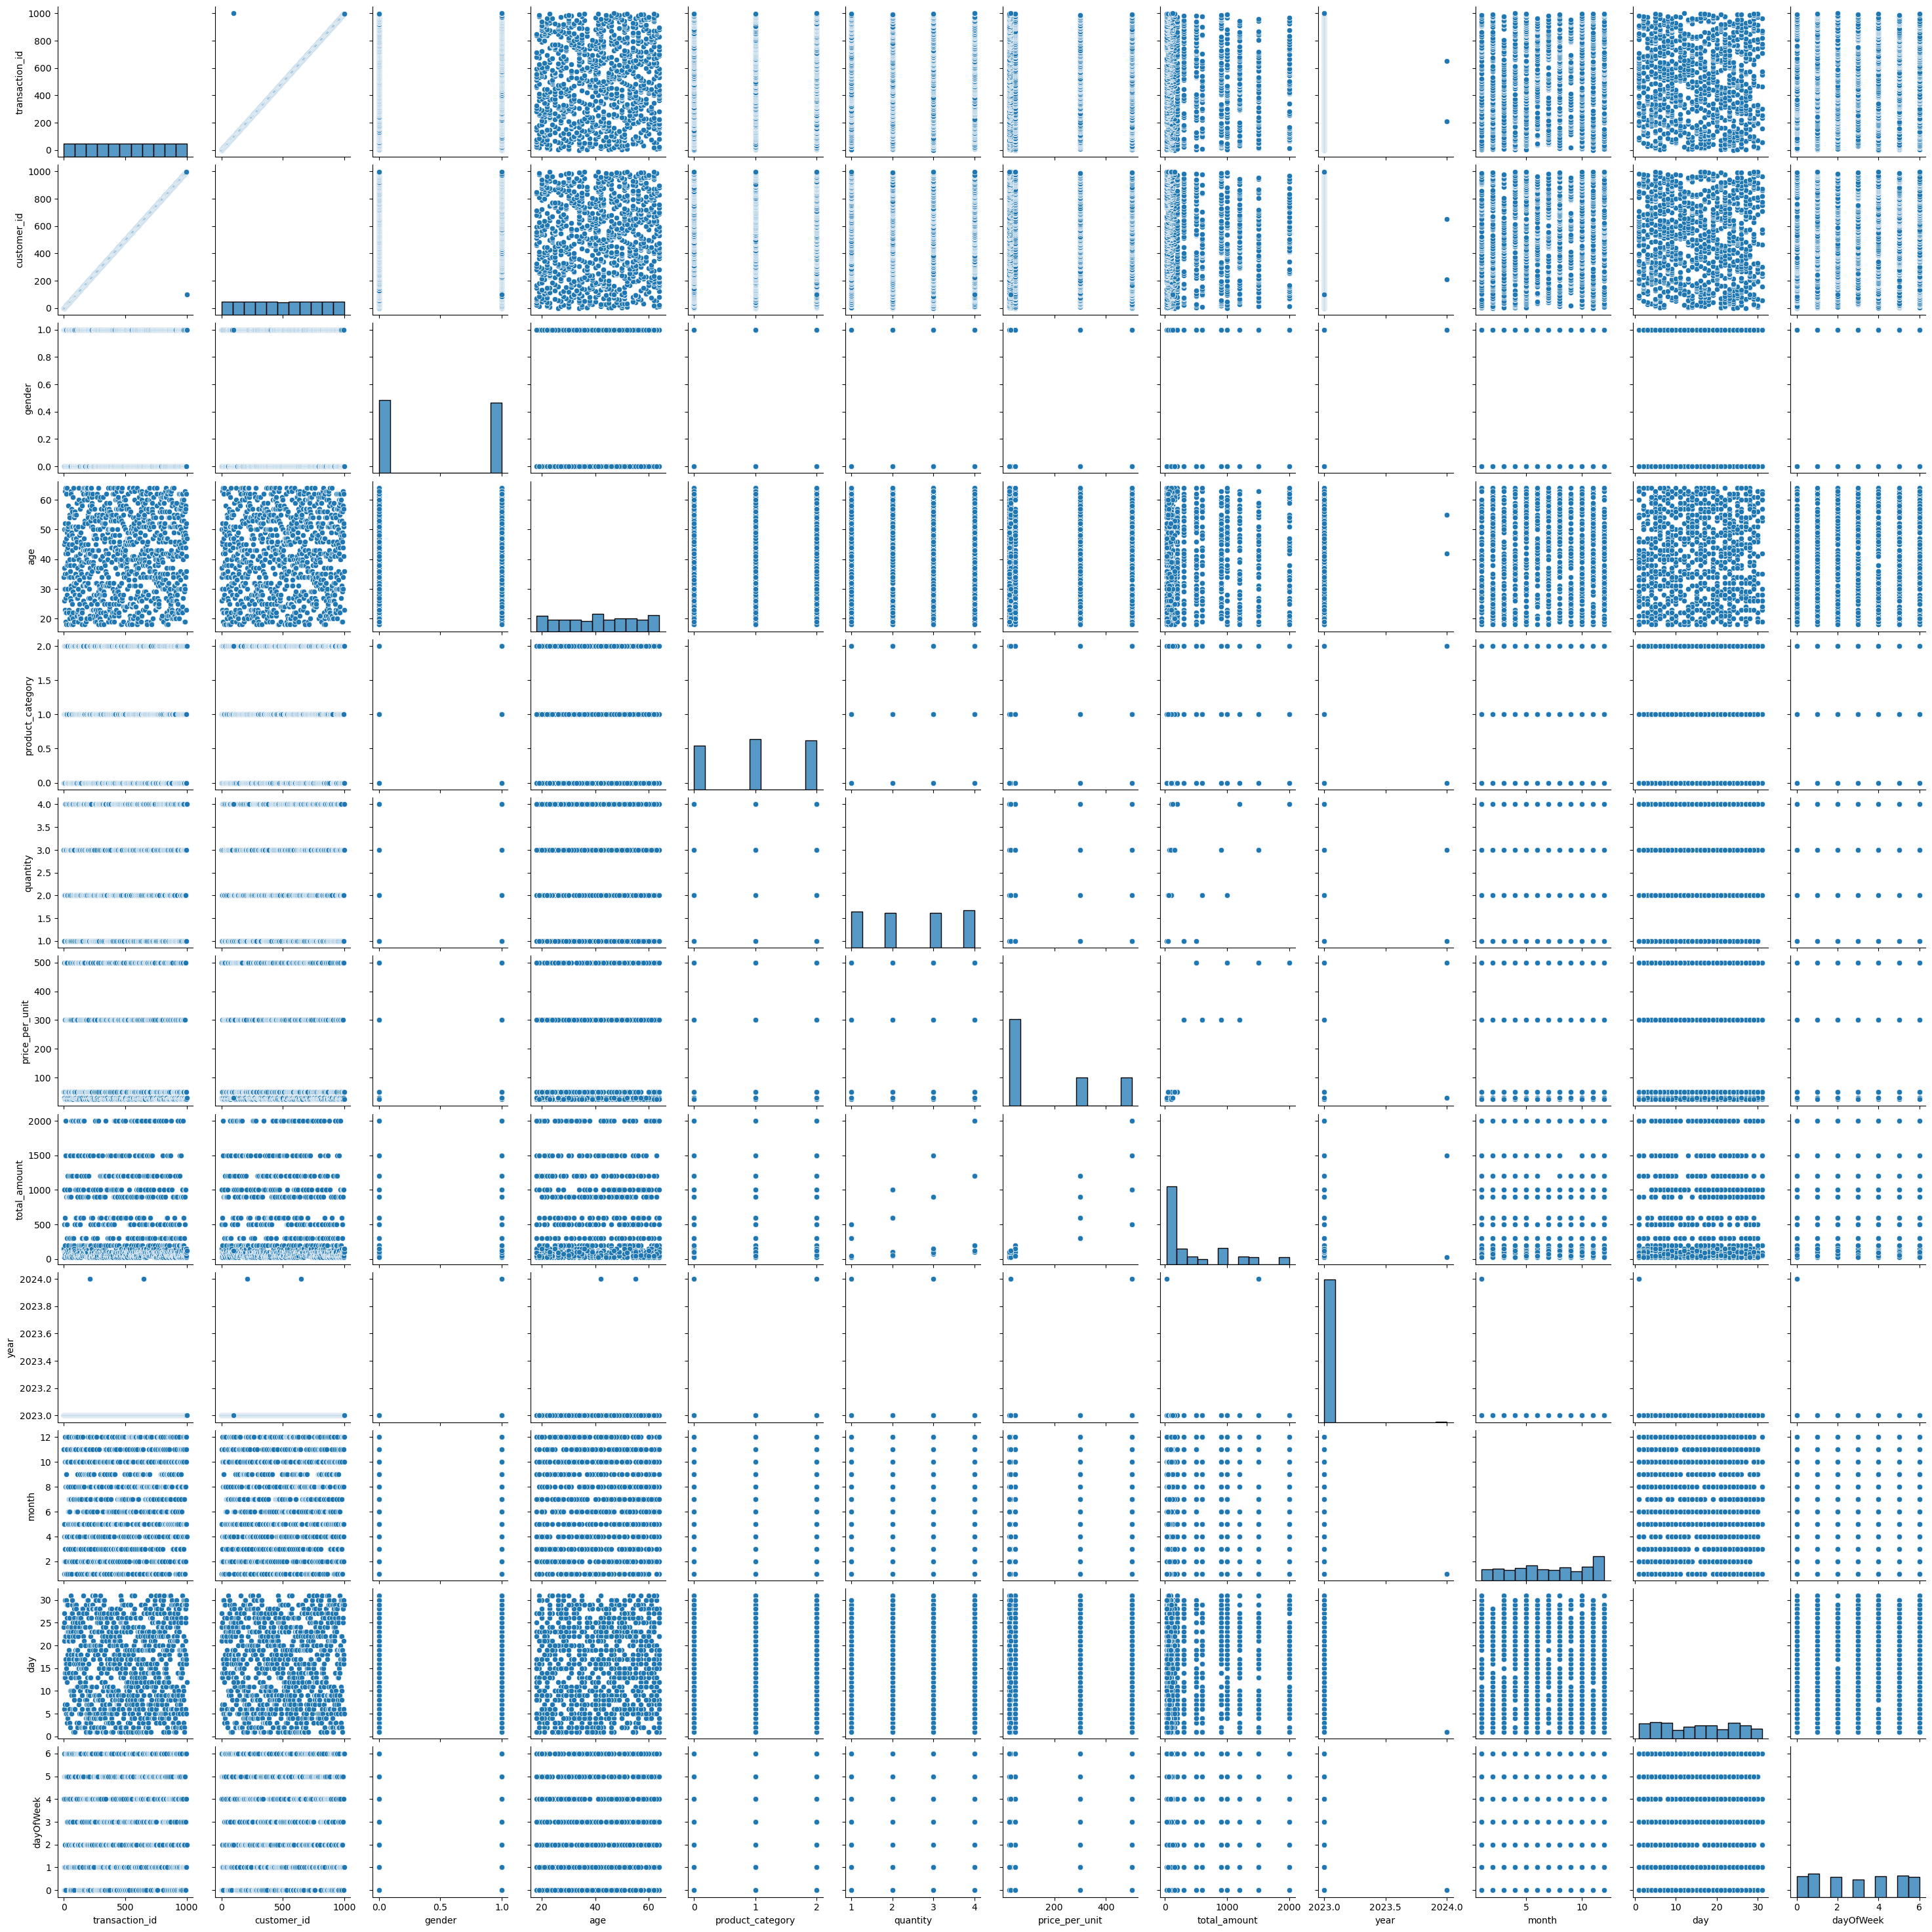

In [43]:
sns.pairplot(df)

In [44]:

# Save the DataFrame to a CSV file
df.to_csv('data/clean_data.csv', index=False)